First thing we do is load in the data set customer_segmentation.csv and begin to inspect it to understand.

In [117]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the CSV file into a DataFrame
df = pd.read_csv('customer_segmentation.csv')

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Display information about the DataFrame (data types, non-null counts, etc.)
print("\nInformation about the DataFrame:")
print(df.info())

# Summary statistics for numerical columns
print("\nSummary statistics for numerical columns:")
print(df.describe())

# Check for any missing values in the DataFrame
print("\nMissing values check:")
print(df.isnull().sum())

# Check for duplicate rows in the DataFrame
print("\nDuplicate rows check:")
print(df.duplicated().sum())


First few rows of the DataFrame:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  Accepted

In [118]:
null_values = df.isnull().sum()

print(null_values)

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


To improve accuracy we can attempt to scale numerical data as well as feature extract the best features to reduce noise and increase accuracy using dimensionality reduction. PCA most likely.

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [120]:
# Display all columns in the DataFrame
print("All columns in the DataFrame:")
print(df.columns)

# Select non-numerical columns
non_numerical_columns = df.select_dtypes(exclude=['number']).columns

# Display non-numerical columns
print("Non-numerical columns:")
print(non_numerical_columns)

# Check the number of unique labels for each non-numerical column
for column in non_numerical_columns:
    unique_labels = df[column].nunique()
    print(f"Column '{column}' has {unique_labels} unique labels.")

All columns in the DataFrame:
Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')
Non-numerical columns:
Index(['Education', 'Marital_Status', 'Dt_Customer'], dtype='object')
Column 'Education' has 5 unique labels.
Column 'Marital_Status' has 8 unique labels.
Column 'Dt_Customer' has 663 unique labels.


It should be noted that the column containing the dates of purchase 'Dt_customer' contains  two different data formats, so for this first round of experimentation, we decided to drop the date column. Later on in the course of the project, we intend to properly format and use the date column to contribute to the clustering dataset. 


The rest of the catgorical features were onehot encoded.

In [121]:
# Drop the 'Dt_Customer' column
df.drop(columns=['Dt_Customer'], inplace=True)

# Perform one-hot encoding for 'Education', 'Marital_Status'
df_encoded = pd.get_dummies(df, columns=['Education', 'Marital_Status'])

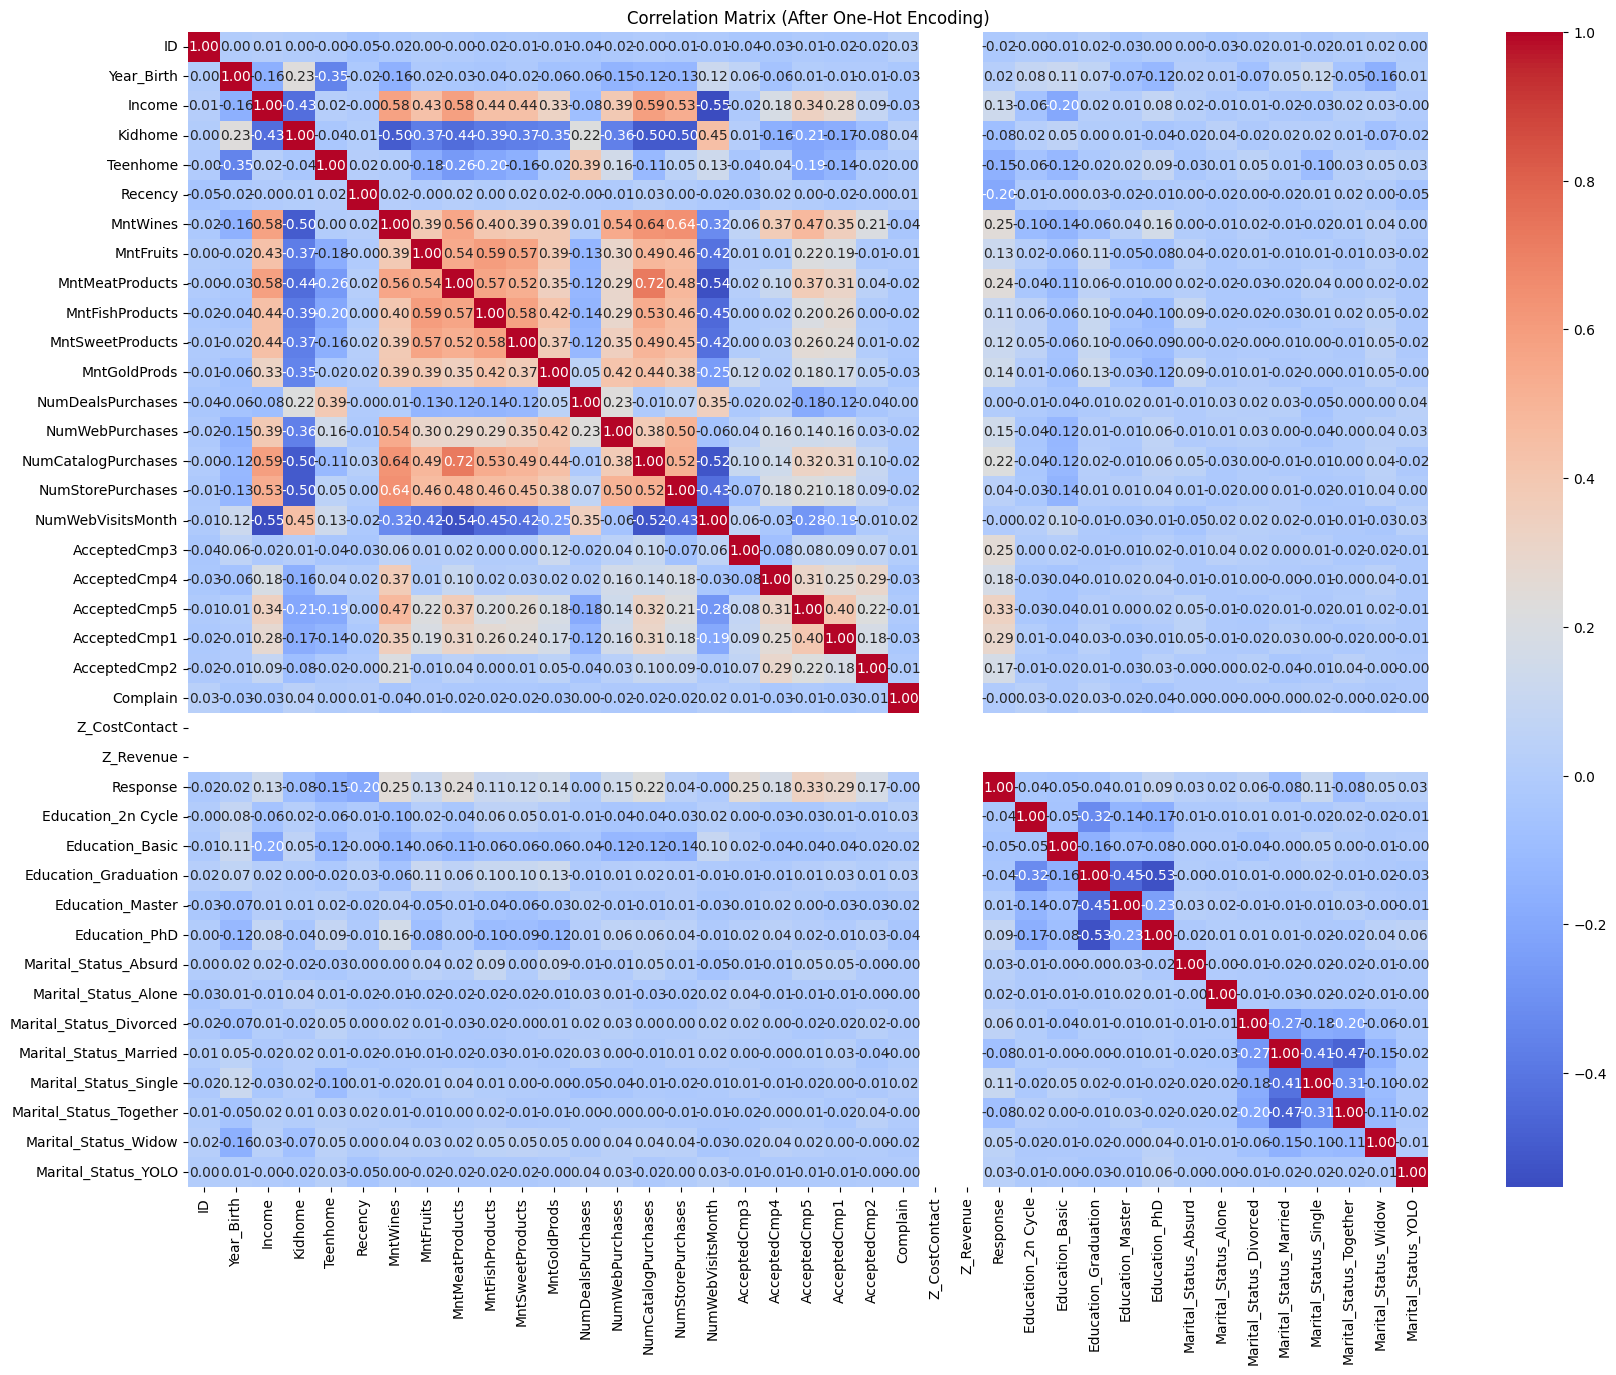

In [122]:
# Create a correlation matrix for the encoded DataFrame
correlation_matrix_encoded = df_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix_encoded, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (After One-Hot Encoding)')
plt.show()

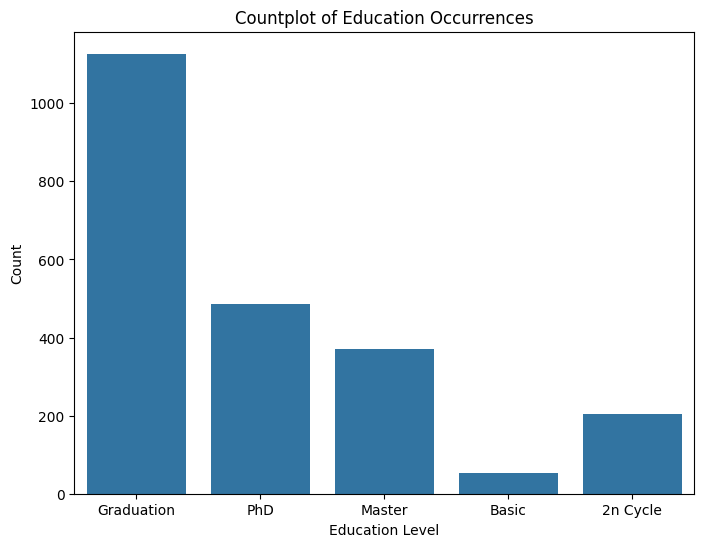

In [123]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Education', data=df)
plt.title('Countplot of Education Occurrences')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

Since the correalation matrix was too complex to determine best features, we performed PCA to stream line preliminary feature selection and model trials. 

In [124]:
X_scaled = StandardScaler().fit_transform(df_encoded)

X_scaled = pd.DataFrame(X_scaled)

# X_scaled = pd.DataFrame(df_encoded)
# X_scaled = df_encoded


print("Shape of scaled data before PCA:")
print(X_scaled.shape)

X_scaled = X_scaled.dropna()


pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


data_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Shape of scaled data after PCA:")
print(data_pca.shape)

Shape of scaled data before PCA:
(2240, 39)
Shape of scaled data after PCA:
(2216, 29)


Since we have extracted the best features to aid in classification, we can now fit the Kmeans model to the data set and examine the clusters that form.

In [125]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [126]:
# Perform K-means clustering
num_clusters = 2  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_pca)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
wcss = kmeans.inertia_
print(f"WCSS :  {wcss}")
print(f"Silhouette Score: {silhouette_avg}")

WCSS :  66697.42821193421
Silhouette Score: 0.17625227254144252


In [146]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
# silhouette_scores = []
for k in range(1, 11):  # Trying k from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)  # Within-cluster sum of squares
    # silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

In [147]:
silhouette_scores = []
for k in range(2, 11):  # Trying k from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

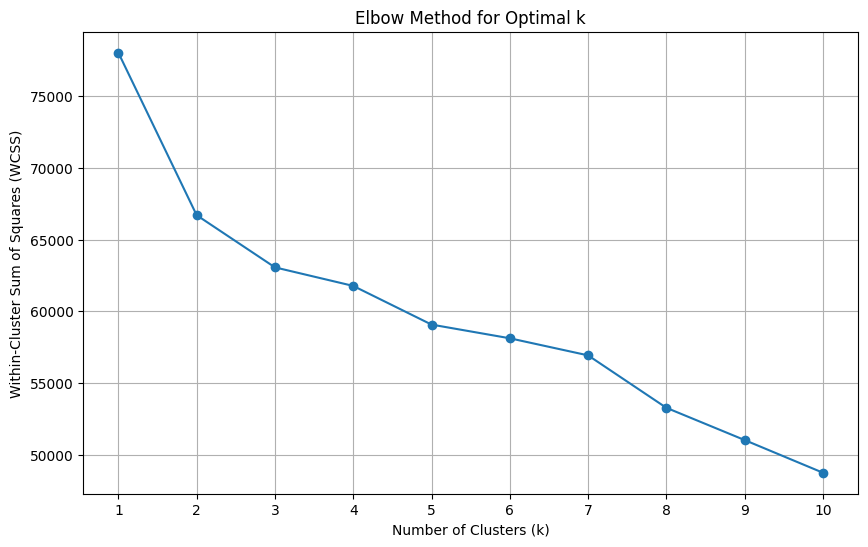

In [149]:
# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

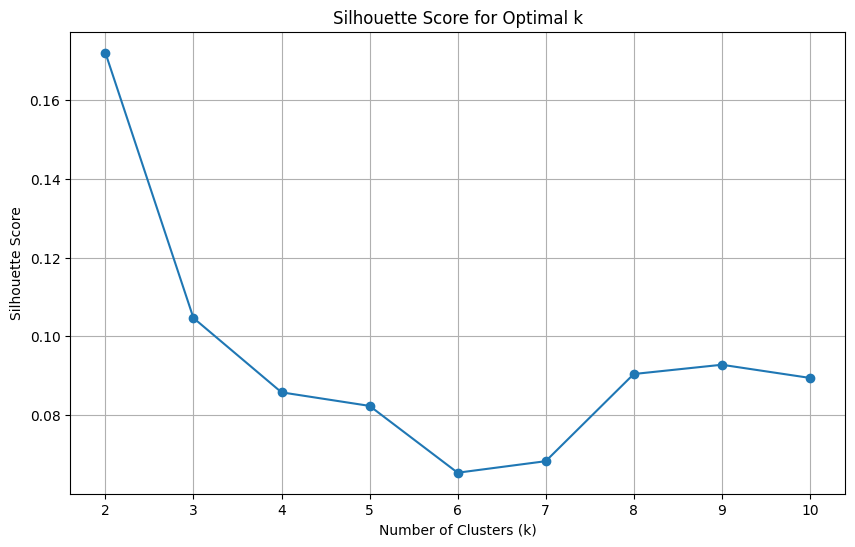

In [150]:
# Plot the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

In [130]:
# Perform K-means clustering
num_clusters = 2  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_pca)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
wcss = kmeans.inertia_
print(f"WCSS :  {wcss}")
print(f"Silhouette Score: {silhouette_avg}")

WCSS :  66697.42821193421
Silhouette Score: 0.17625227254144252


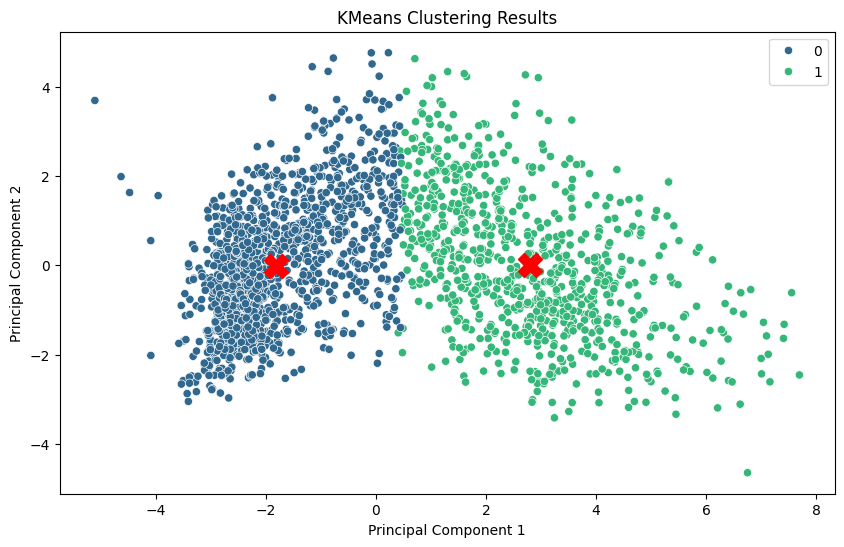

In [131]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data_pca)

cluster_labels = kmeans.predict(data_pca)


op = data_pca.values

plt.figure(figsize=(10, 6))
sns.scatterplot(x=op[:, 0], y=op[:, 1], hue=cluster_labels, palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering Results')
plt.show()

Trying KMeans Using Scaled, but non-pca Values.

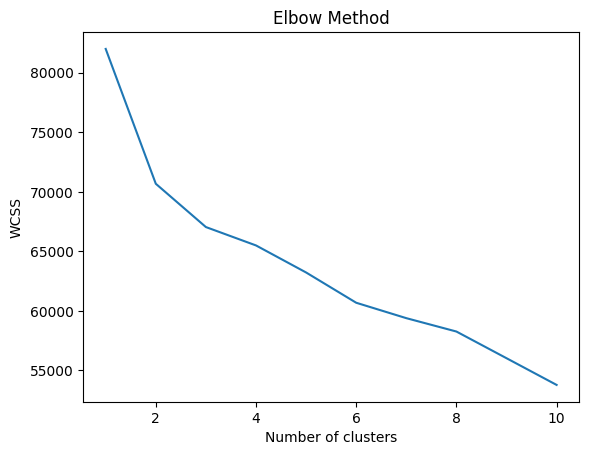

In [144]:
#Naomi kmeans thingy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    #kmeans = KMeans(n_clusters=64, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

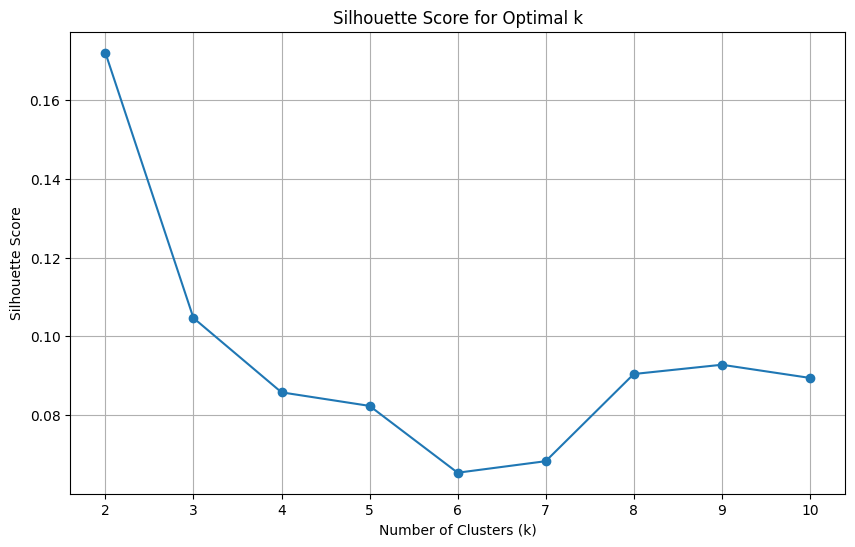

In [136]:
silhouette_scores = []
for k in range(2, 11):  # Trying k from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)  # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))


plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()



Using the scaled, non-PCA data, we see a more clearly defined elbow, also at k=2 as seen with the previous results.
We now attempt Kmeans Clustering on this data.


In [142]:
num_clusters = 2  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_scaled)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
wcss = kmeans.inertia_
print(f"WCSS :  {wcss}")
print(f"Silhouette Score: {silhouette_avg}")

WCSS :  70680.04235547637
Silhouette Score: 0.17152435971263608


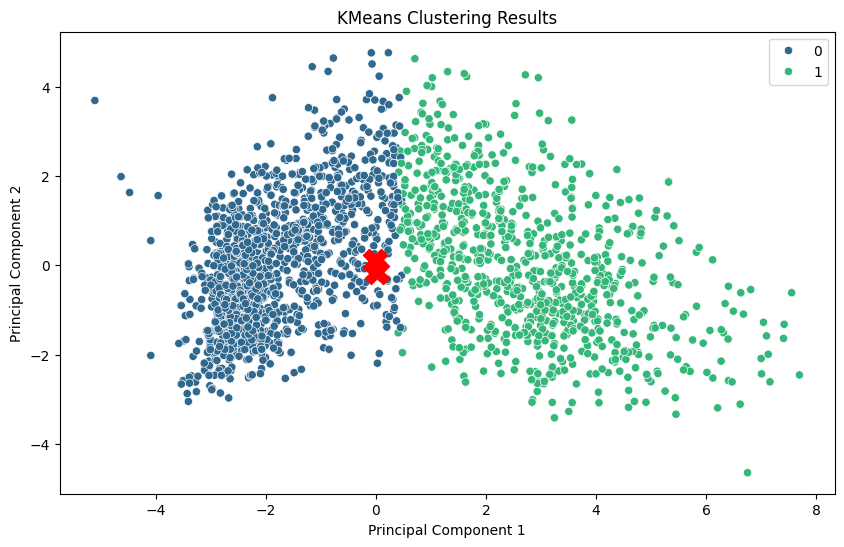

In [143]:
#fit and plot results of kmeans with non-PCA values
# optimal_k = 2
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# kmeans.fit(X_scaled)

cluster_labels = kmeans.predict(X_scaled)


op = data_pca.values

plt.figure(figsize=(10, 6))
sns.scatterplot(x=op[:, 0], y=op[:, 1], hue=cluster_labels, palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering Results')
plt.show()

With this data, a similar shape of clusters was formed, however the centroids were close together. 

DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN


eps = 0.1  # Distance threshold for DBSCAN
min_samples = 15 # Minimum number of samples for DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_scaled)


labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


plt.figure(figsize=(8, 6))


# plt.scatter(X_scaled[labels == -1, 0], X_scaled[labels == -1, 1], c='black', marker='.', label='Noise')


# for i in range(n_clusters_):
#     plt.scatter(X_scaled[labels == i, 0], X_scaled[labels == i, 1], label='Cluster ' + str(i))


# plt.title('DBSCAN Clustering on PCA-transformed Data')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.show()


Estimated number of clusters: 0
Estimated number of noise points: 2216


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

After trying both Kmeans and DBSCAN we found a WCSS of 66697.42821193421 and Silhouette Score: 0.17625227254144252

We tried to run DBSCAN on the current data. However, this algorithm found all the data to be noise so more hyperparameter tuning is required. If tuning does not help, other methods may be explored (changing the way we preprocess the data, eg different encoding/scaling/running without pca etc)


Hierarchical Clustering was not yet attempted.
